In [1]:
# Import
import pandas as pd
import numpy as np
from datetime import timedelta
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
import seaborn as sns

## Data Preprocessinng

In [2]:
# reading csv file of weather data
wt_df = pd.read_csv(r"data/weather_data.csv")
wt_df = wt_df.drop(['Unnamed: 0'], axis=1)
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,,,,,
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,,,,,
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,,,,,
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,,,,,


In [3]:
# reading csv file of weekly dengue cases data
dg_df = pd.read_csv(r"data/weekly-number-of-cases.csv")

# dengue dataframe
dg_df.dropna(inplace=True)
dg_df

,year,eweek,type_dengue,number
0,2014,1,Dengue,436.0
1,2014,1,DHF,1.0
2,2014,2,Dengue,479.0
3,2014,2,DHF,0.0
4,2014,3,Dengue,401.0
...,...,...,...,...
523,2018,50,DHF,1.0
524,2018,51,Dengue,127.0
525,2018,51,DHF,1.0
526,2018,52,Dengue,160.0


In [4]:
# adding Dengue and DHF cases and then reset index to save the sum to dataframe
d_df = dg_df.groupby(['year','eweek'])['number'].sum().reset_index()
d_df

,year,eweek,number
0,2014,1,437.0
1,2014,2,479.0
2,2014,3,401.0
3,2014,4,336.0
4,2014,5,234.0
...,...,...,...
256,2018,48,109.0
257,2018,49,114.0
258,2018,50,108.0
259,2018,51,128.0


In [5]:
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    261 non-null    int64  
 1   eweek   261 non-null    int64  
 2   number  261 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.2 KB


In [6]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Station                        89898 non-null  object
 1   Year                           89898 non-null  int64 
 2   Month                          89898 non-null  int64 
 3   Day                            89898 non-null  int64 
 4   Daily Rainfall Total (mm)      89898 non-null  object
 5   Highest 30 Min Rainfall (mm)   89898 non-null  object
 6   Highest 60 Min Rainfall (mm)   89898 non-null  object
 7   Highest 120 Min Rainfall (mm)  89898 non-null  object
 8   Mean Temperature (°C)          89898 non-null  object
 9   Maximum Temperature (°C)       89769 non-null  object
 10  Minimum Temperature (°C)       89757 non-null  object
 11  Mean Wind Speed (km/h)         89898 non-null  object
 12  Max Wind Speed (km/h)          89731 non-null  object
dtypes

In [7]:
# data cleaning and transformation
df_obj = wt_df.select_dtypes(['object'])
# stripe empty space before tranform data types to numeric
wt_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
# wt_df[df_obj.columns] = df_obj.apply(lambda x: float(x.str.split()[0].replace('\x97', '')))
wt_df = wt_df.replace('\x97', '')
wt_df = wt_df.replace(r'^\s*$', np.nan, regex=True)


In [8]:
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN


In [9]:
# data transformation
wt_df['Daily Rainfall Total (mm)'] = wt_df['Daily Rainfall Total (mm)'].astype(float)
wt_df['Mean Temperature (°C)'] = wt_df['Mean Temperature (°C)'].astype(float)
wt_df['Mean Wind Speed (km/h)'] = wt_df['Mean Wind Speed (km/h)'].astype(float)

In [10]:
# Remove NUll ??? --> No need since group by will ignore NaN by default
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Station                        89898 non-null  object 
 1   Year                           89898 non-null  int64  
 2   Month                          89898 non-null  int64  
 3   Day                            89898 non-null  int64  
 4   Daily Rainfall Total (mm)      87337 non-null  float64
 5   Highest 30 Min Rainfall (mm)   80439 non-null  object 
 6   Highest 60 Min Rainfall (mm)   80439 non-null  object 
 7   Highest 120 Min Rainfall (mm)  80439 non-null  object 
 8   Mean Temperature (°C)          31063 non-null  float64
 9   Maximum Temperature (°C)       33619 non-null  object 
 10  Minimum Temperature (°C)       33605 non-null  object 
 11  Mean Wind Speed (km/h)         34551 non-null  float64
 12  Max Wind Speed (km/h)          34269 non-null 

In [11]:
# add a dataframe field

wt_df["Year"] = wt_df["Year"].astype(str)
wt_df["Month"] = wt_df["Month"].astype(str)
wt_df["Day"] = wt_df["Day"].astype(str)

wt_df["Date"] = pd.to_datetime(wt_df["Year"] + "/" + wt_df["Month"] + "/" + wt_df["Day"])
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2,2014-01-01
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2,2014-01-02
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2,2014-01-03
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8,2014-01-04
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0,2014-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-27
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-28
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-29
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN,2018-12-30


In [12]:
# add a week number field to be join key with dengue dataframe
wt_df['Week_Number'] = wt_df['Date'].dt.isocalendar().week
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,Week_Number
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2,2014-01-01,1
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2,2014-01-02,1
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2,2014-01-03,1
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8,2014-01-04,1
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0,2014-01-05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-27,52
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-28,52
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-29,52
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN,2018-12-30,52


In [13]:
wt_df['Week_year']= wt_df['Year'].astype(int)

In [14]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        89898 non-null  object        
 1   Year                           89898 non-null  object        
 2   Month                          89898 non-null  object        
 3   Day                            89898 non-null  object        
 4   Daily Rainfall Total (mm)      87337 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   80439 non-null  object        
 6   Highest 60 Min Rainfall (mm)   80439 non-null  object        
 7   Highest 120 Min Rainfall (mm)  80439 non-null  object        
 8   Mean Temperature (°C)          31063 non-null  float64       
 9   Maximum Temperature (°C)       33619 non-null  object        
 10  Minimum Temperature (°C)       33605 non-null  object        
 11  Mean Wind Speed

In [15]:
wt_df['Week_year'] = wt_df.apply(lambda row: row['Week_year']+1 if ((row['Month']=='12') and (row['Week_Number']==1)) else row['Week_year'],  axis=1)
wt_df[(wt_df['Month']=='12') & (wt_df['Week_Number']==1)]

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,Week_Number,Week_year
332,Admiralty,2014,12,29,1.0,1.0,1.0,1.0,25.2,28.2,24.1,13.3,50.0,2014-12-29,1,2015
333,Admiralty,2014,12,30,0.0,0.0,0.0,0.0,24.8,26.0,23.9,12.1,45.7,2014-12-30,1,2015
334,Admiralty,2014,12,31,0.0,0.0,0.0,0.0,25.9,28.1,24.4,11.2,36.7,2014-12-31,1,2015
697,Ang Mo Kio,2014,12,29,3.0,2.2,2.2,2.6,25.5,29.0,23.6,8.4,37.8,2014-12-29,1,2015
698,Ang Mo Kio,2014,12,30,0.0,0.0,0.0,0.0,25.0,26.5,24.1,7.1,28.4,2014-12-30,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88437,Tuas South,2018,12,31,5.0,3.8,3.8,3.8,27.5,31.3,25.3,7.2,31.3,2018-12-31,1,2019
88802,Tuas West,2018,12,31,9.4,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019
89167,Ulu Pandan,2018,12,31,51.4,32.0,42.8,50.6,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019
89532,Upper Peirce Reservoir,2018,12,31,9.6,5.4,6.4,6.8,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019


In [16]:
w_df = wt_df.groupby(['Week_year','Week_Number']).agg({'Daily Rainfall Total (mm)' : 'mean', 'Mean Temperature (°C)' : 'mean', 'Mean Wind Speed (km/h)': 'mean'}).reset_index()
w_df['week'] = w_df['Week_Number'].astype(int)
w_df['year'] = w_df['Week_year'].astype(int)
w_df = w_df.drop('Week_Number', axis=1)
w_df = w_df.drop('Week_year', axis=1)
w_df

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h),week,year
0,4.013191,26.521429,8.748889,1,2014
1,7.426140,26.502521,7.839683,2,2014
2,0.023708,26.245378,12.849206,3,2014
3,0.000000,25.783193,12.439683,4,2014
4,0.000000,26.210256,12.272222,5,2014
...,...,...,...,...,...
258,9.385890,27.361905,5.721368,49,2018
259,12.300313,26.844954,6.608264,50,2018
260,3.454955,27.990000,7.391870,51,2018
261,0.769697,28.495327,8.190083,52,2018


In [17]:
df = pd.merge(w_df, d_df,  how='left', left_on = ['year','week'], right_on = ['year','eweek'])
df = df.drop('eweek', axis=1)
df = df.rename(columns={'Daily Rainfall Total (mm)': 'avg rainfall', 'Mean Temperature (°C)': 'avg temperature', 'Mean Wind Speed (km/h)':'avg wind speed'})
df.dropna(inplace=True)
df

,avg rainfall,avg temperature,avg wind speed,week,year,number
0,4.013191,26.521429,8.748889,1,2014,437.0
1,7.426140,26.502521,7.839683,2,2014,479.0
2,0.023708,26.245378,12.849206,3,2014,401.0
3,0.000000,25.783193,12.439683,4,2014,336.0
4,0.000000,26.210256,12.272222,5,2014,234.0
...,...,...,...,...,...,...
257,9.253235,27.456250,6.954032,48,2018,109.0
258,9.385890,27.361905,5.721368,49,2018,114.0
259,12.300313,26.844954,6.608264,50,2018,108.0
260,3.454955,27.990000,7.391870,51,2018,128.0


# Time Series Analysis


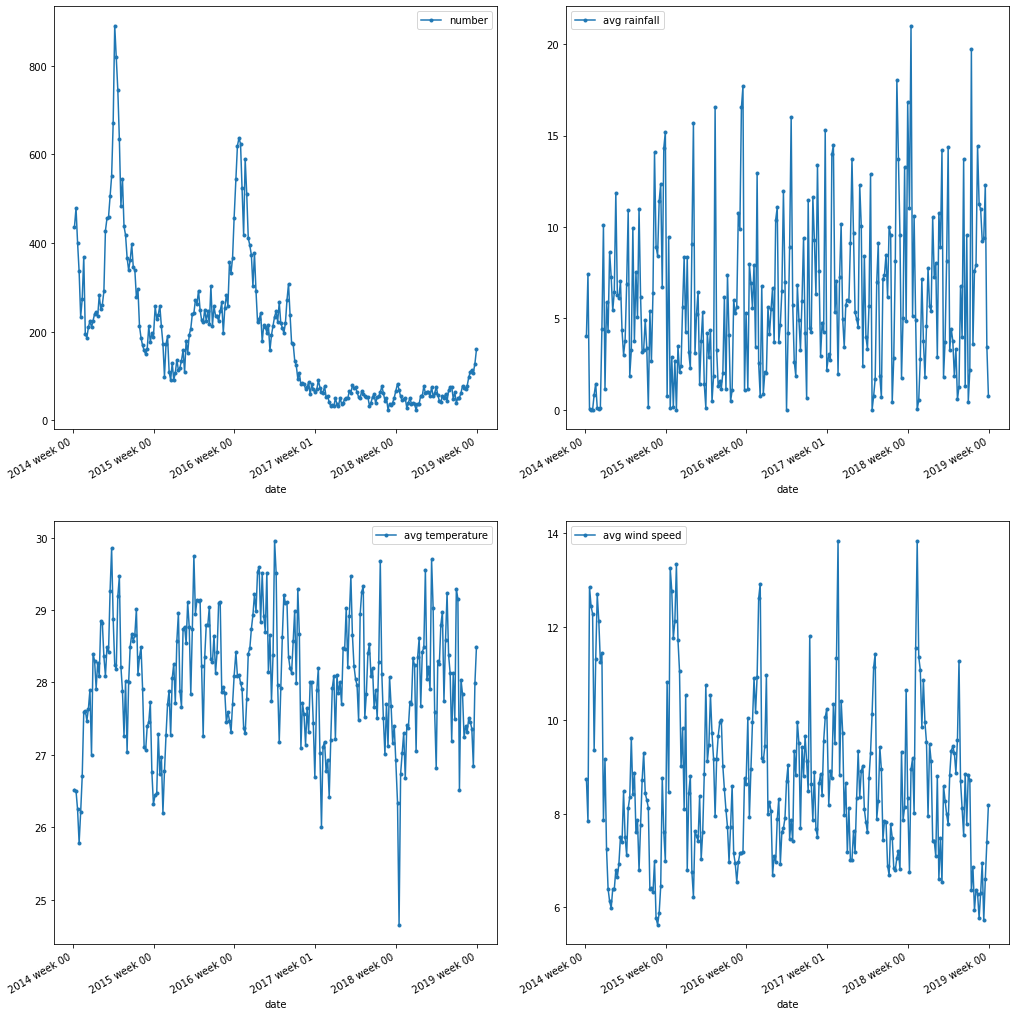

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Determine the date
df['date'] = pd.to_datetime(df.assign(day=1, month=1)[['year', 'month', 'day']])+pd.to_timedelta(df.week*7, unit='days')

# Plot
fig, ax = plt.subplots(2,2,figsize=(15, 15))
df.plot(x='date', y='number', marker='.', ax=ax[0,0])
df.plot(x='date', y='avg rainfall', marker='.', ax=ax[0,1])
df.plot(x='date', y='avg temperature', marker='.', ax=ax[1,0])
df.plot(x='date', y='avg wind speed', marker='.', ax=ax[1,1])

fig.tight_layout(pad=5.0)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

In [19]:
data = df[['avg rainfall','avg temperature','avg wind speed','number','date']]
data.set_index('date', inplace=True)
data = data.diff().dropna()
# data

In [20]:
df[df['year']==2016]

,avg rainfall,avg temperature,avg wind speed,week,year,number,date
105,1.133333,28.417293,10.042222,1,2016,545.0,2016-01-08
106,7.985088,28.086466,7.932143,2,2016,620.0,2016-01-15
107,6.928190,28.109302,8.969343,3,2016,637.0,2016-01-22
108,5.562798,27.996032,9.961194,4,2016,624.0,2016-01-29
109,7.934337,27.908943,10.897692,5,2016,525.0,2016-02-05
110,3.441486,27.371930,10.166942,6,2016,419.0,2016-02-12
111,12.933731,27.295935,10.931818,7,2016,590.0,2016-02-19
112,2.532738,27.769841,12.603759,8,2016,511.0,2016-02-26
113,0.727485,28.400000,12.918705,9,2016,411.0,2016-03-04
114,6.781341,28.471756,9.203571,10,2016,395.0,2016-03-11


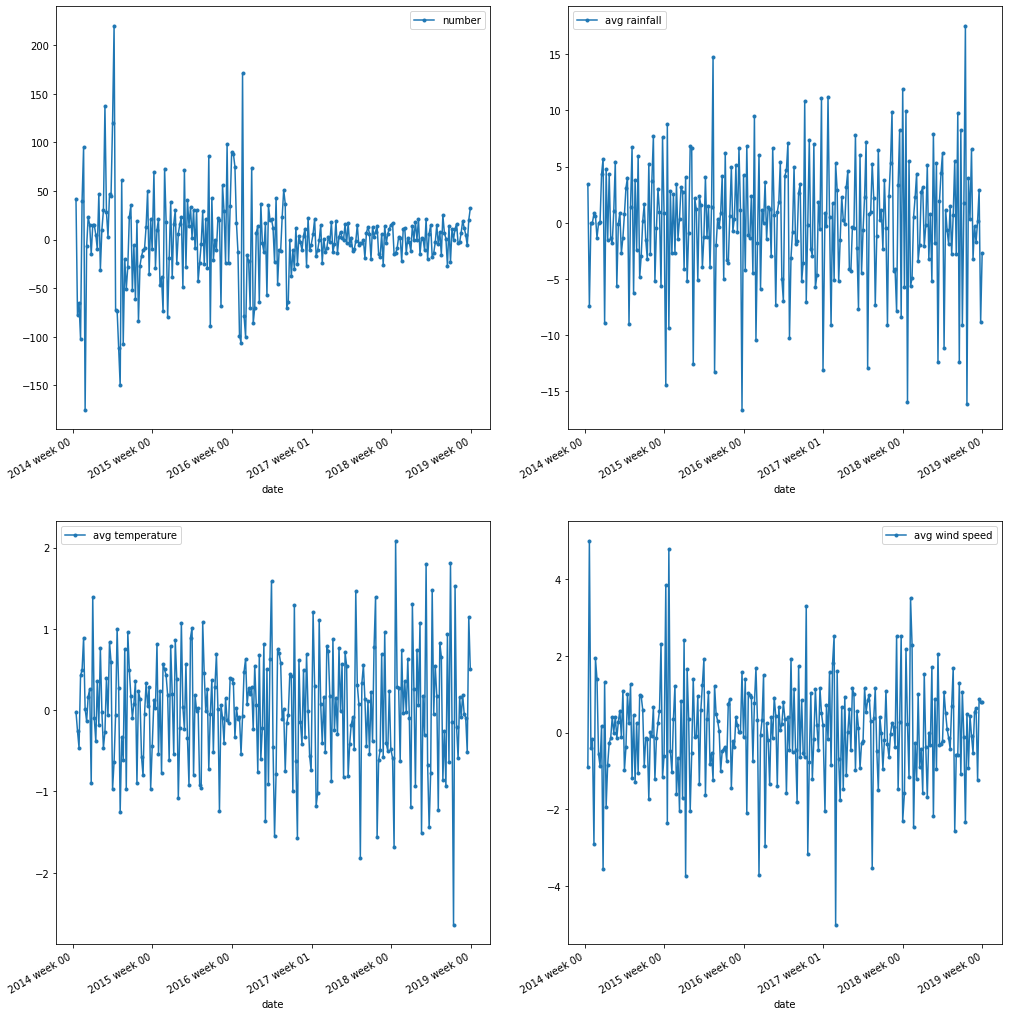

In [21]:
# Plot to check if time series is stationary

fig, ax = plt.subplots(2,2,figsize=(15, 15))
data.plot( y='number',use_index=True, marker='.', ax=ax[0,0])
data.plot( y='avg rainfall',use_index=True, marker='.', ax=ax[0,1])
data.plot( y='avg temperature',use_index=True, marker='.', ax=ax[1,0])
data.plot( y='avg wind speed',use_index=True, marker='.', ax=ax[1,1])

fig.tight_layout(pad=5.0)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

### Granger Causality Test to investigate causality of data. 

Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series. In the MTS, we will test the causality of all combinations of pairs of variables.

##### Granger Causality Hypothesis:
* H0 (Null Hypothesis) : lagged x-values do not explain the variation in y, so the x does not cause y. 
* H1 (Alternative Hypothesis) : x causes y

We use grangercausalitytests function in the package statsmodels to do the test and the output of the matrix is the minimum p-value when computes the test for all lags up to maxlag(=22). The critical value we use is 5% and if the p-value of a pair of variables is smaller than 0.05, we could say with 95% confidence that a predictor x causes a response y.

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

variables=data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
maxlag=22

for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(data[[row, col]], maxlag=24, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]

matrix

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,avg rainfall_x,avg temperature_x,avg wind speed_x,number_x
avg rainfall_y,1.0000,0.0070,0.0002,0.0848
avg temperature_y,0.2498,1.0000,0.7440,0.4155
avg wind speed_y,0.0000,0.0000,1.0000,0.0844
number_y,0.0052,0.0901,0.0149,1.0000


#### Findings:
From the result above, each column represents a predictor x of each variable and each row represents the response y and the p-value of each pair of variables are shown in the matrix. Take the value 0.0385 (<0.05) in (row 1, column 2) as an example, it refers that number_x is causal to avg rainfall_y because we fail to reject H0 (x-values do not explain the variation in y).

As all values are all below 0.05 except the diagonal, we could reject that the null hypothesis and this dataset is a good candidate of VectorARIMA modeling.

### Stationary Test
As VectorARIMA requires time series to be stationary, we will use one popular statistical test – Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset.  

The Null Hypothesis is that the data has unit root and is not stationary and the significant value is 0.05.

In [23]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)

 avg rainfall : P-Value = 0.0 => Stationary. 
 avg temperature : P-Value = 0.0 => Stationary. 
 avg wind speed : P-Value = 0.0 => Stationary. 
 number : P-Value = 0.0 => Stationary. 


#### Findings:
From the results above, we could see none of these varibles is stationary. Let us use the differencing method to make them stationary.

In [24]:
df

,avg rainfall,avg temperature,avg wind speed,week,year,number,date
0,4.013191,26.521429,8.748889,1,2014,437.0,2014-01-08
1,7.426140,26.502521,7.839683,2,2014,479.0,2014-01-15
2,0.023708,26.245378,12.849206,3,2014,401.0,2014-01-22
3,0.000000,25.783193,12.439683,4,2014,336.0,2014-01-29
4,0.000000,26.210256,12.272222,5,2014,234.0,2014-02-05
...,...,...,...,...,...,...,...
257,9.253235,27.456250,6.954032,48,2018,109.0,2018-12-03
258,9.385890,27.361905,5.721368,49,2018,114.0,2018-12-10
259,12.300313,26.844954,6.608264,50,2018,108.0,2018-12-17
260,3.454955,27.990000,7.391870,51,2018,128.0,2018-12-24


In [25]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
data.index = data.index.to_period('W')
data

,avg rainfall,avg temperature,avg wind speed,number
date,,,,
2014-01-13/2014-01-19,3.412948,-0.018908,-0.909206,42.0
2014-01-20/2014-01-26,-7.402432,-0.257143,5.009524,-78.0
2014-01-27/2014-02-02,-0.023708,-0.462185,-0.409524,-65.0
2014-02-03/2014-02-09,0.000000,0.427063,-0.167460,-102.0
2014-02-10/2014-02-16,0.821277,0.493105,-2.900794,40.0
...,...,...,...,...
2018-12-03/2018-12-09,-1.711202,-0.050172,0.644941,12.0
2018-12-10/2018-12-16,0.132654,-0.094345,-1.232665,5.0
2018-12-17/2018-12-23,2.914423,-0.516951,0.886897,-6.0


## Train-Test Split

In [27]:
test_obs = 12
train = data[:-test_obs]
test = data[-test_obs:]

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


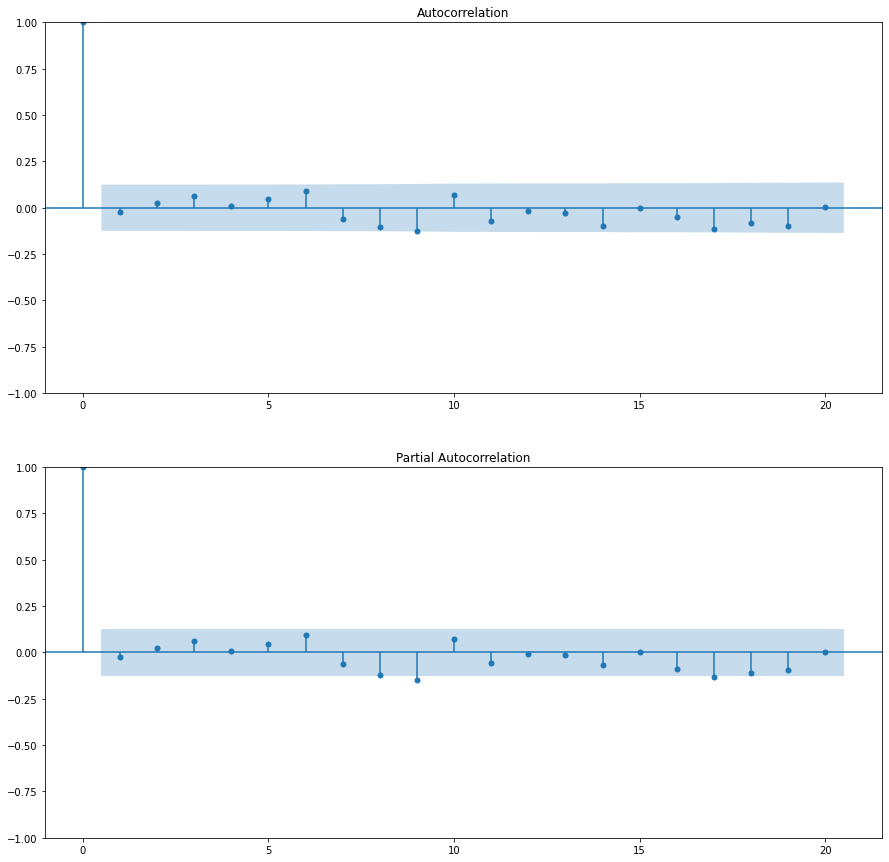

In [28]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(train['number'], lags = 20,ax=ax[0]);
plot_pacf(train['number'], lags = 20,ax=ax[1]);

#### Findings: 
Both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to AR or MA alone. Since there are multiple variables, I will use vector ARIMA model to fit data.

## Model

### Vector Auto Regression (VAR)
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#:~:text=A%20Multivariate%20time%20series%20has,used%20for%20forecasting%20future%20values.

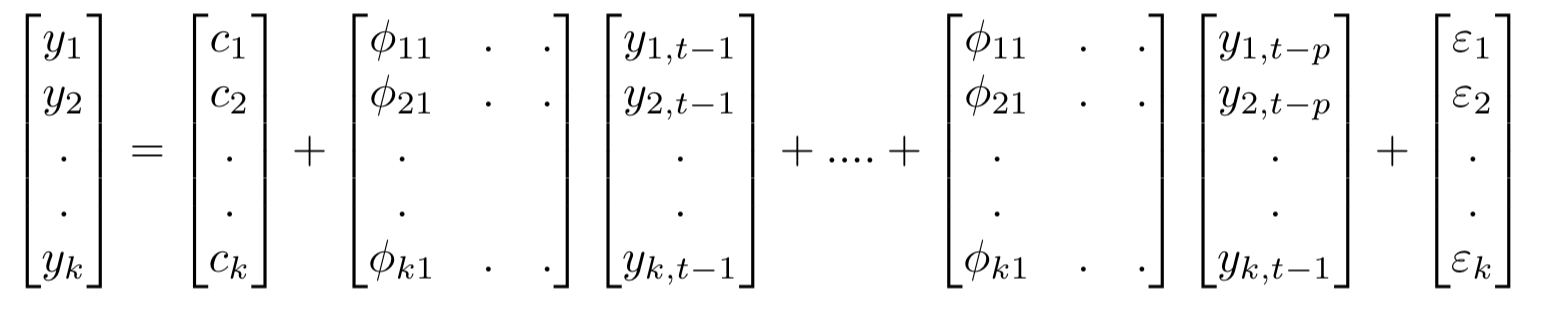

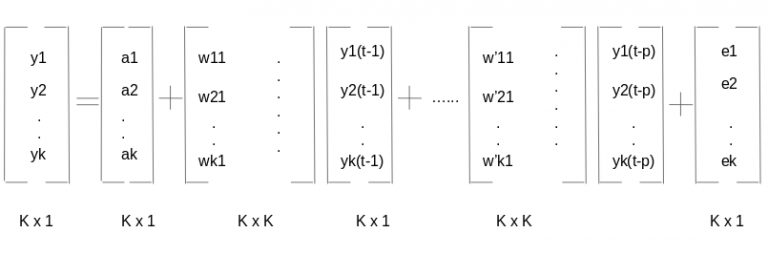

In [29]:
model = VAR(train)

In [30]:
x = model.select_order(maxlags=16)
x.summary()

,AIC,BIC,FPE,HQIC
0,10.00,10.06,2.213e+04,10.03
1,9.716,10.01*,1.659e+04,9.836
2,9.589,10.13,1.461e+04,9.806
3,9.470,10.24,1.297e+04,9.782*
4,9.432*,10.45,1.249e+04*,9.841
5,9.433,10.68,1.252e+04,9.938
6,9.435,10.93,1.256e+04,10.04
7,9.443,11.17,1.269e+04,10.14
8,9.492,11.46,1.336e+04,10.29
9,9.553,11.76,1.425e+04,10.44


In [31]:
results_aic = []
results_bic = []
results_hqic = []
for p in range(1,10):
    results = model.fit(p)
    results_aic.append(results.aic)
    results_bic.append(results.bic)
    results_hqic.append(results.hqic)

Text(0, 0.5, 'HQIC')

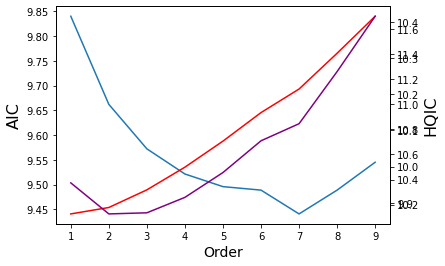

In [32]:
#define subplots
fig,ax = plt.subplots()
#add first line to plot
ax.plot(list(np.arange(1,10,1)), results_aic)
#add x-axis label
ax.set_xlabel('Order', fontsize=14)
#add y-axis label
ax.set_ylabel('AIC', fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
#add second line to plot
ax2.plot(list(np.arange(1,10,1)), results_bic, color='red')
#add second y-axis label
ax2.set_ylabel('BIC', fontsize=16)

#define third y-axis that shares x-axis with current plot
ax3 = ax.twinx()
#add third line to plot
ax3.plot(list(np.arange(1,10,1)), results_hqic, color ='Purple')
#add third y-axis label
ax2.set_ylabel('HQIC', fontsize=16)

In [68]:
p = 5
#p = 6
results =  model.fit(p)
# results.summary()

In [69]:
# make predictions
pred = results.forecast(results.endog, steps = test_obs)
pred = pd.DataFrame(pred, columns = data.columns + '_pred')
pred

,avg rainfall_pred,avg temperature_pred,avg wind speed_pred,number_pred
0,3.441993,-0.405500,-0.657595,4.175684
1,0.018750,-0.351001,-0.501112,-3.988416
2,0.620114,0.115549,-0.166625,9.728786
3,-0.759149,0.133727,-0.071866,-13.229046
4,-0.629190,0.123855,0.383875,-3.400863
5,0.466992,0.004284,-0.041608,1.729017
6,0.027425,-0.033558,-0.075572,3.629345
7,0.388810,-0.082000,-0.168260,1.173755
8,-0.136065,0.042780,0.018615,-0.344207
9,-0.133407,0.037865,0.041628,-3.389947


In [70]:
d = data.tail(test_obs)
pred.index = d.index
pred

,avg rainfall_pred,avg temperature_pred,avg wind speed_pred,number_pred
date,,,,
2018-10-15/2018-10-21,3.441993,-0.405500,-0.657595,4.175684
2018-10-22/2018-10-28,0.018750,-0.351001,-0.501112,-3.988416
2018-10-29/2018-11-04,0.620114,0.115549,-0.166625,9.728786
2018-11-05/2018-11-11,-0.759149,0.133727,-0.071866,-13.229046
2018-11-12/2018-11-18,-0.629190,0.123855,0.383875,-3.400863
2018-11-19/2018-11-25,0.466992,0.004284,-0.041608,1.729017
2018-11-26/2018-12-02,0.027425,-0.033558,-0.075572,3.629345
2018-12-03/2018-12-09,0.388810,-0.082000,-0.168260,1.173755
2018-12-10/2018-12-16,-0.136065,0.042780,0.018615,-0.344207


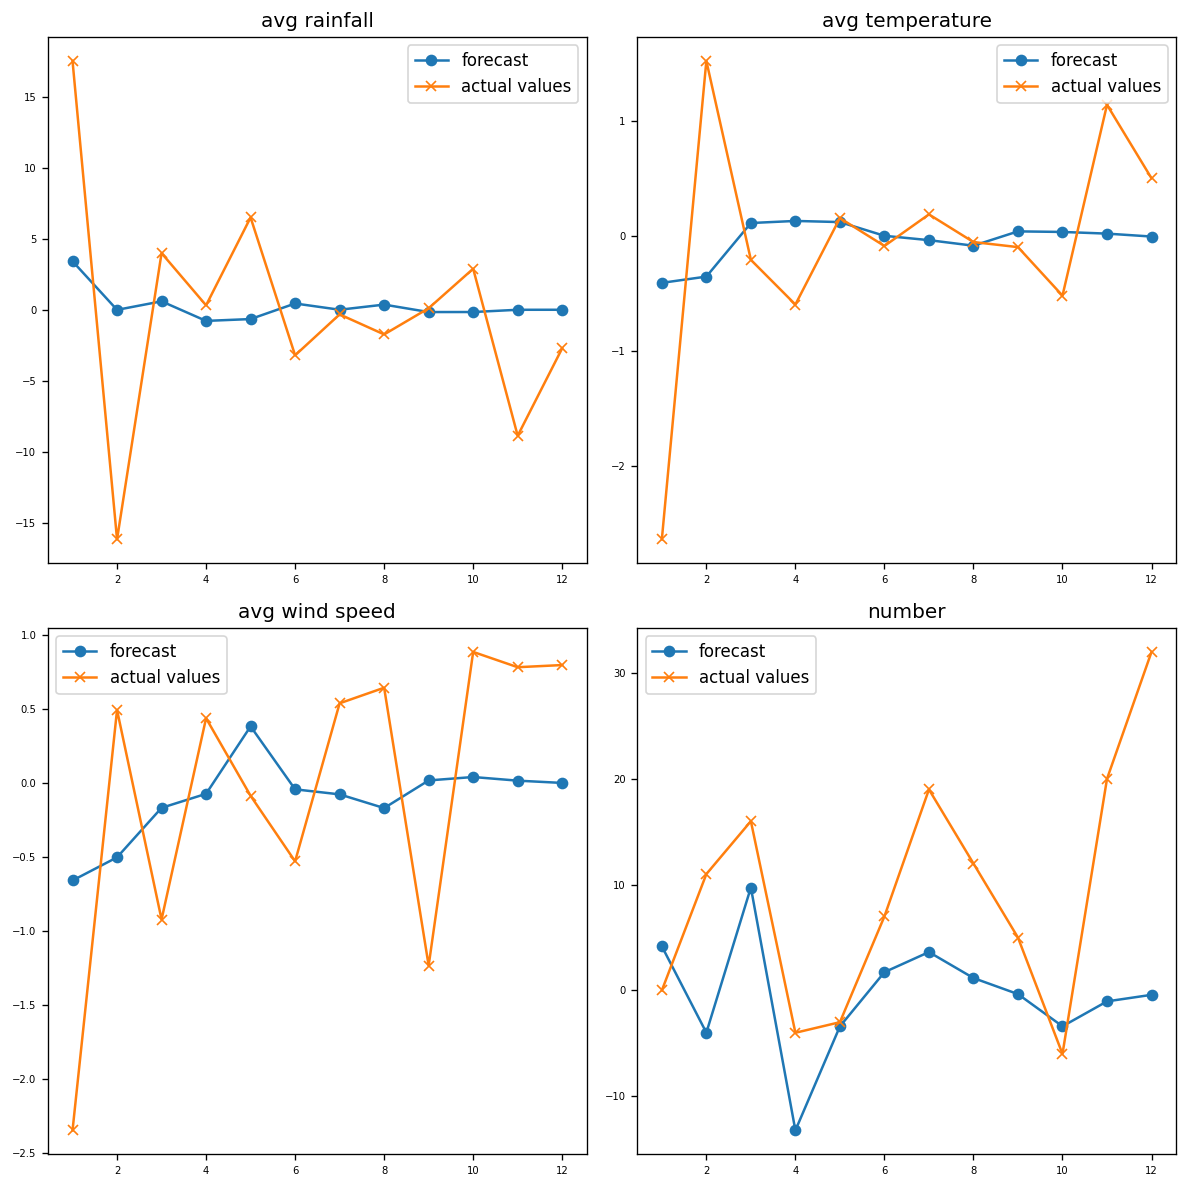

In [71]:
def plot_forecast_actuals(data, data_actual, data_predict):
    fig, axes = plt.subplots(nrows=int(len(data_actual.columns)/2), ncols=2, dpi=120, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        ax.plot(list(np.arange(1,13,1)),data_predict[col + '_pred'], label='forecast', marker='o')
        ax.plot(list(np.arange(1,13,1)),data_actual[col], label='actual values', marker='x')
        ax.legend(loc='best')
        ax.set_title(data.columns[i])
        ax.set_title(col)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout();
    
plot_forecast_actuals(data=data, data_actual=test, data_predict = pred)

In [72]:
def invert_transformation(data_diff, pred):
    forecast = pred.copy()
    columns = data.columns
    for col in columns:
        forecast[str(col)+'_pred'] = data[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
    return forecast

output = invert_transformation(data, pred)
#print(output.loc[:, ['^RUT_pred']])
#output = DataFrame(output['^RUT_pred'])
output

,avg rainfall_pred,avg temperature_pred,avg wind speed_pred,number_pred
date,,,,
2018-10-15/2018-10-21,0.756735,0.099827,0.140618,36.175684
2018-10-22/2018-10-28,0.775485,-0.251174,-0.360495,32.187268
2018-10-29/2018-11-04,1.395599,-0.135625,-0.527120,41.916054
2018-11-05/2018-11-11,0.636450,-0.001898,-0.598986,28.687008
2018-11-12/2018-11-18,0.007260,0.121957,-0.215111,25.286145
2018-11-19/2018-11-25,0.474252,0.126241,-0.256718,27.015162
2018-11-26/2018-12-02,0.501677,0.092682,-0.332290,30.644507
2018-12-03/2018-12-09,0.890487,0.010682,-0.500550,31.818262
2018-12-10/2018-12-16,0.754422,0.053462,-0.481935,31.474055


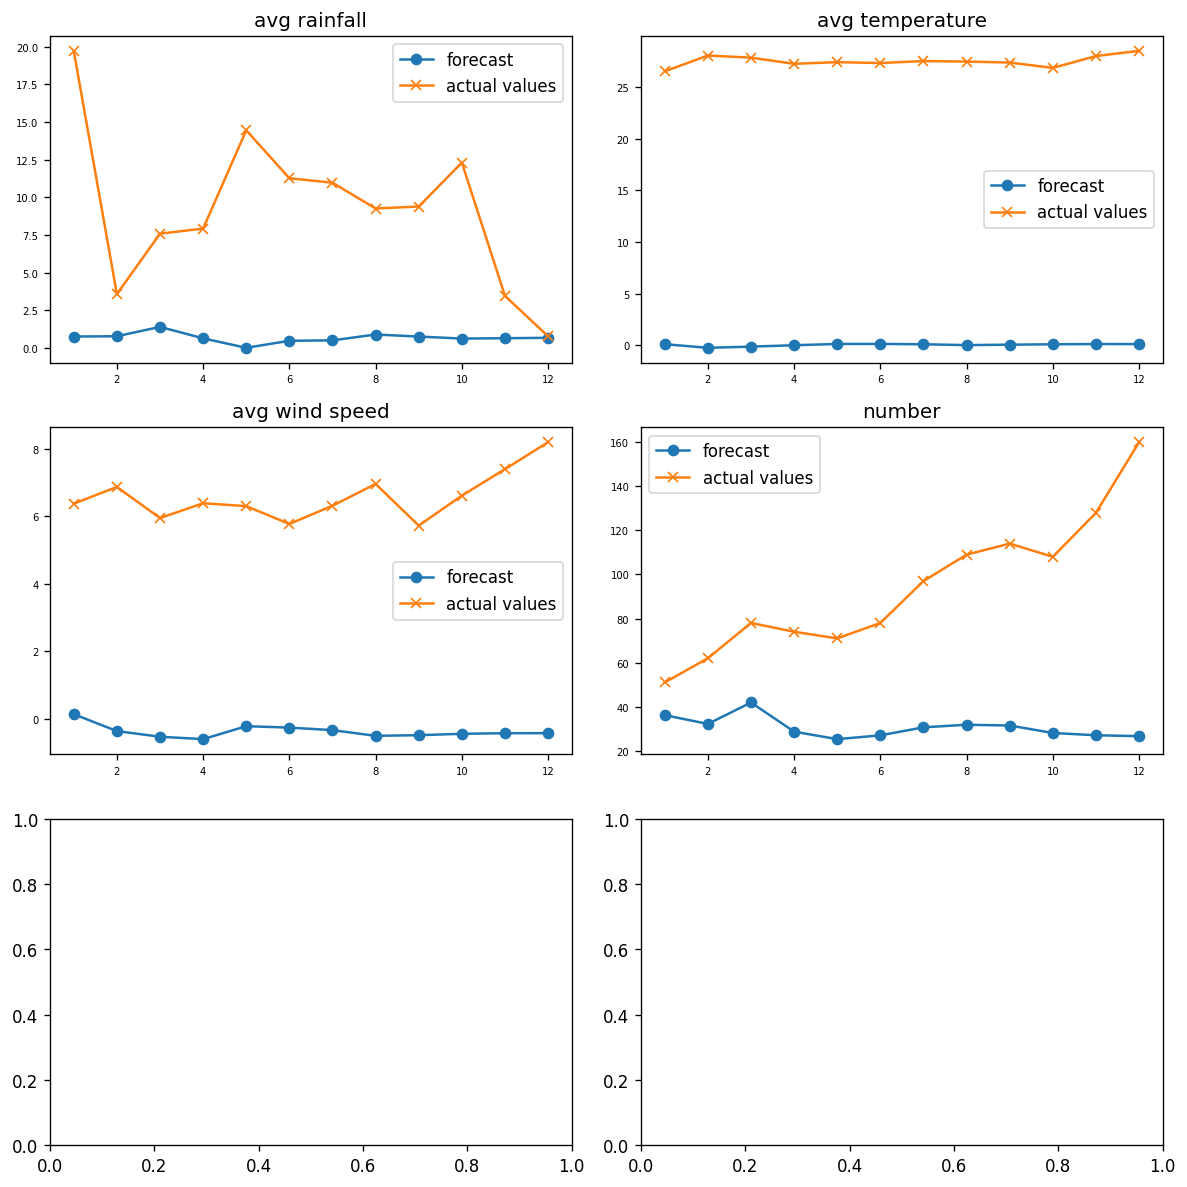

In [73]:
plot_forecast_actuals(data=data, data_actual=df.tail(12), data_predict = output)

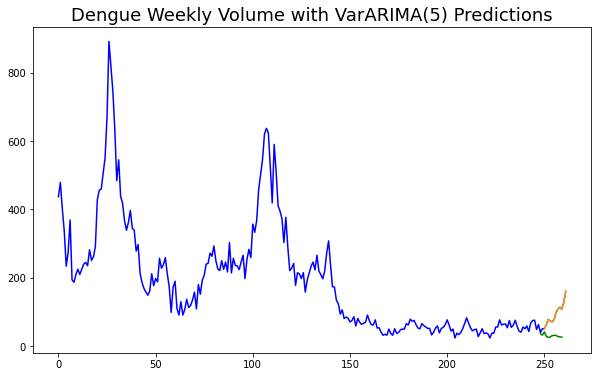

In [74]:
plt.figure(figsize=(10,6))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(list(np.arange(len(df)-test_obs,len(df),1)),output['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();